# Google Drive Mounting 

In [153]:
from google.colab import drive

In [154]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Load x_features and y_features



In [155]:
import pickle
#x_features = pickle.load(open('/content/drive/MyDrive/Capstone_Project_Covid_Normal/x_features.pkl','rb'))
#y_features = pickle.load(open('/content/drive/MyDrive/Capstone_Project_Covid_Normal/y_features.pkl','rb'))
x_features = pickle.load(open('/content/drive/MyDrive/Capstone_Project_3Classes/x_features.pkl','rb'))
y_features = pickle.load(open('/content/drive/MyDrive/Capstone_Project_3Classes/y_features.pkl','rb'))

In [156]:
import pickle
#x_features = pickle.load(open('/content/drive/MyDrive/Capstone_Project/x_features_resized.pkl','rb'))
#y_features = pickle.load(open('/content/drive/MyDrive/Capstone_Project/y_features_resized.pkl','rb'))

'others'

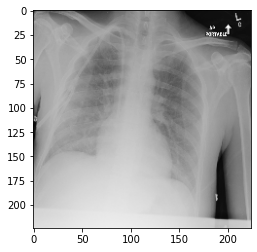

In [157]:
import matplotlib.pyplot as plt
plt.imshow(x_features[1])
y_features[1]

In [158]:
x_features[0].shape,y_features[0]

((224, 224, 3), 'others')

In [159]:
import tensorflow 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
ytrain = le.fit_transform(y_features)
y_train_data = tensorflow.keras.utils.to_categorical(ytrain, 3)
y_train_data.shape,y_train_data[0]

((1504, 3), array([0., 0., 1.], dtype=float32))

In [160]:
y_train_data[0]

array([0., 0., 1.], dtype=float32)

In [161]:
ytrain

array([2, 2, 2, ..., 2, 2, 2])

# Normalize the training data and convert into 4 dimensions so that it can be used as an input to conv layers in the model

In [162]:
import numpy  
xtrain_arr = numpy.array(x_features) 
xtrain_arr.shape,xtrain_arr[0].shape

((1504, 224, 224, 3), (224, 224, 3))

In [163]:
x_train_data = xtrain_arr.astype('float32')

#Normalizing the input
x_train_data /= 255.0
print('x_train_data shape:', x_train_data.shape)
print(x_train_data.shape[0], 'train samples')

x_train_data shape: (1504, 224, 224, 3)
1504 train samples


In [164]:
y_train_data.shape

(1504, 3)

## Split the data into training and validation data from `x_train_data` and `y_train_data` obtained from above steps

In [165]:
#def shuffle(matrix, target, test_proportion):
#    ratio = int(matrix.shape[0]/test_proportion) #should be int
#    X_train = matrix[ratio:,:]
#    X_test =  matrix[:ratio,:]
#    Y_train = target[ratio:,:]
#    Y_test =  target[:ratio,:]
#    return X_train, X_test, Y_train, Y_test

#x_train, x_val, y_train, y_val = shuffle(x_train_data, y_train_data, 3)

In [166]:
from sklearn.model_selection import train_test_split
x_train_test, x_val, y_train_test, y_val = train_test_split(x_train_data, y_train_data, test_size=0.20, random_state=1,stratify=y_train_data,shuffle=True)

In [167]:
x_train, x_test, y_train, y_test = train_test_split(x_train_test, y_train_test, test_size=0.10, random_state=1,stratify=y_train_test,shuffle=True)

In [168]:
x_train.shape,y_train.shape,x_val.shape,y_val.shape

((1082, 224, 224, 3), (1082, 3), (301, 224, 224, 3), (301, 3))

In [169]:
import pandas as pd
pd.DataFrame(y_train).value_counts()

0    1    2  
0.0  0.0  1.0    362
1.0  0.0  0.0    360
0.0  1.0  0.0    360
dtype: int64

In [170]:
import pandas as pd
pd.DataFrame(y_val).value_counts()

0    1    2  
0.0  0.0  1.0    101
1.0  0.0  0.0    100
0.0  1.0  0.0    100
dtype: int64

# Model Building

### Transfer Learning

Download the vgg wieght file from here : https://github.com/MinerKasch/applied_deep_learning/blob/master/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

In [171]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [213]:
img_in = Input(x_train.shape[1:])              #input of model 
model = DenseNet121(include_top= False , # remove  the 3 fully-connected layers at the top of the network
                weights='imagenet',      # pre train weight 
                input_tensor= img_in, 
                input_shape= x_train.shape[1:],
                pooling ='avg') 

x = model.output  
predictions = Dense(3, activation="sigmoid", name="predictions")(x)    # fuly connected layer for predict class 
model = Model(inputs=img_in, outputs=predictions)

In [215]:
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics='accuracy')

In [216]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_10 (ZeroPadding2 (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_10[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [219]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

In [220]:
#Training on the dataset
model_history = model.fit(x_train, y_train,
          batch_size=32,
          epochs=80,
          verbose=1,
          validation_data=(x_val, y_val),callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

Epoch 1/80
34/34 [==============================] - 23s 426ms/step - loss: 1.0680 - accuracy: 0.5227 - val_loss: 29.3257 - val_accuracy: 0.3322
Epoch 2/80
34/34 [==============================] - 13s 390ms/step - loss: 0.6338 - accuracy: 0.6706 - val_loss: 12.6790 - val_accuracy: 0.3821
Epoch 3/80
34/34 [==============================] - 13s 383ms/step - loss: 0.5167 - accuracy: 0.7623 - val_loss: 2.8668 - val_accuracy: 0.4950
Epoch 4/80
34/34 [==============================] - 13s 376ms/step - loss: 0.4532 - accuracy: 0.7968 - val_loss: 5.9429 - val_accuracy: 0.3355
Epoch 5/80
34/34 [==============================] - 13s 374ms/step - loss: 0.3449 - accuracy: 0.8419 - val_loss: 1.8391 - val_accuracy: 0.5249
Epoch 6/80
34/34 [==============================] - 13s 376ms/step - loss: 0.4373 - accuracy: 0.8188 - val_loss: 1.4134 - val_accuracy: 0.5947
Epoch 7/80
34/34 [==============================] - 13s 384ms/step - loss: 0.2647 - accuracy: 0.9006 - val_loss: 1.5075 - val_accuracy: 0.61

In [221]:
from sklearn import metrics
predictions = model.predict(x_train)
y_train_pred = []
y_train_act = []
for val in predictions:
    y_train_pred.append(np.argmax(val))

for val1 in y_train:
    y_train_act.append(np.argmax(val1))

cr=metrics.classification_report(y_train_act,y_train_pred)
cm=metrics.confusion_matrix(y_train_act,y_train_pred)
print(cr)
print(cm)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       360
           1       1.00      1.00      1.00       360
           2       1.00      1.00      1.00       362

    accuracy                           1.00      1082
   macro avg       1.00      1.00      1.00      1082
weighted avg       1.00      1.00      1.00      1082

[[360   0   0]
 [  0 360   0]
 [  0   0 362]]


In [222]:
from sklearn import metrics
predictions = model.predict(x_val)
y_val_pred = []
y_val_act = []
for val in predictions:
    y_val_pred.append(np.argmax(val))

for val1 in y_val:
    y_val_act.append(np.argmax(val1))

cr=metrics.classification_report(y_val_act,y_val_pred)
cm=metrics.confusion_matrix(y_val_act,y_val_pred)
print(cr)
print(cm)

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       100
           1       0.71      0.81      0.76       100
           2       0.74      0.67      0.70       101

    accuracy                           0.80       301
   macro avg       0.81      0.80      0.80       301
weighted avg       0.81      0.80      0.80       301

[[92  3  5]
 [ 0 81 19]
 [ 3 30 68]]


In [223]:
from sklearn import metrics
predictions = model.predict(x_test)
y_test_pred = []
y_test_act = []
for val in predictions:
  y_test_pred.append(np.argmax(val))

for val1 in y_test:
  y_test_act.append(np.argmax(val1))

cr=metrics.classification_report(y_test_act,y_test_pred)
cm=metrics.confusion_matrix(y_test_act,y_test_pred)
print(cr)
print(cm)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        40
           1       0.80      0.80      0.80        40
           2       0.82      0.78      0.80        41

    accuracy                           0.86       121
   macro avg       0.86      0.86      0.86       121
weighted avg       0.86      0.86      0.86       121

[[40  0  0]
 [ 1 32  7]
 [ 1  8 32]]


In [197]:
x_val.shape

(301, 224, 224, 3)

In [198]:
from sklearn.metrics import roc_auc_score
aurocs = []
y_pred = model.predict(x_val)
for i in range(3):
  try:
    score = roc_auc_score(y_val[:, i], y_pred[:, i])
    aurocs.append(score)
  except ValueError:
    score = 0

In [190]:
aurocs

[0.994776119402985, 0.9073631840796019, 0.8822772277227723]

In [191]:
import numpy as np
mean_auroc = np.mean(aurocs)

In [192]:
mean_auroc

0.9281388437351198

In [199]:
scores_train = model.evaluate(x_train, y_train, verbose=2)
print("Accuracy on Train Data: %.2f%%" % (scores_train[1]*100))

34/34 - 3s - loss: 6.1874e-06 - binary_accuracy: 1.0000
Accuracy on Train Data: 100.00%


In [200]:
scores_val = model.evaluate(x_val, y_val, verbose=2)
print("Accuracy on Val Data: %.2f%%" % (scores_val[1]*100))

10/10 - 1s - loss: 0.5523 - binary_accuracy: 0.8726
Accuracy on Val Data: 87.26%


In [201]:
scores_test = model.evaluate(x_test, y_test, verbose=2)
print("Accuracy on Test Data: %.2f%%" % (scores_test[1]*100))

4/4 - 0s - loss: 0.3360 - binary_accuracy: 0.9091
Accuracy on Test Data: 90.91%


In [202]:
from keras.models import load_model

# Creates a HDF5 file 'my_model.h5'
model.save('final_model.h5')

In [224]:
from tqdm import tqdm
import numpy as np
import cv2

def predict_image(id):
  x_test = []
  y_test = []

  img=cv2.imread('/content/drive/MyDrive/Capstone_Project_3Classes/data/{}'.format(id),1)
  img_resize=cv2.resize(img,(224,224))
  x_test.append(img_resize)
  #y_test.append(lab)
  xtest_arr = numpy.array(x_test) 
  x_test_data = xtest_arr.astype('float32')
  x_test_data /= 255.0
  predictions = model.predict(x_test_data)

  print((np.argmax(predictions)))
  print('Predicted image is', le.inverse_transform([(np.argmax(predictions))])[0])
  #return le.inverse_transform([(np.argmax(predictions))])[0]

In [225]:
predict_image('00000285_002.png')  # Normal 
predict_image('00000324_002.png')  # Normal 
predict_image('covid-19-pneumonia-58-day-3.jpg')  # Covid19
predict_image('covid-19-pneumonia-progression-and-regression-day24.jpg')  # Covid19
predict_image('yxppt-2020-02-19_00-51-27_287214-day8.jpg')  # Covid19
predict_image('00000468_048.png')  # Normal 

1
Predicted image is No Finding
1
Predicted image is No Finding
0
Predicted image is Covid19
0
Predicted image is Covid19
0
Predicted image is Covid19
1
Predicted image is No Finding


In [226]:
from tqdm import tqdm
import numpy as np
import cv2

def predict_image_v(id):
  x_test = []
  y_test = []

  img=cv2.imread('/content/{}'.format(id),1)
  img_resize=cv2.resize(img,(224,224))
  x_test.append(img_resize)
  #y_test.append(lab)
  xtest_arr = numpy.array(x_test) 
  x_test_data = xtest_arr.astype('float32')
  x_test_data /= 255.0
  predictions = model.predict(x_test_data)

  print((np.argmax(predictions)))
  print('Predicted image is', le.inverse_transform([(np.argmax(predictions))])[0])
  #return le.inverse_transform([(np.argmax(predictions))])[0]

In [227]:
predict_image_v('Pneumonia_00000061_015.png')

2
Predicted image is others


In [228]:
predict_image_v('Hernia_00017755_002.png')

2
Predicted image is others


In [230]:
predict_image_v('normal.jpg')

1
Predicted image is No Finding


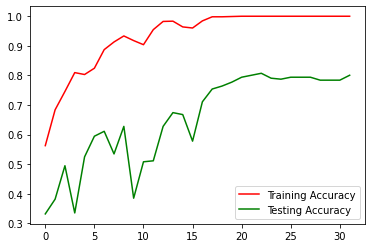

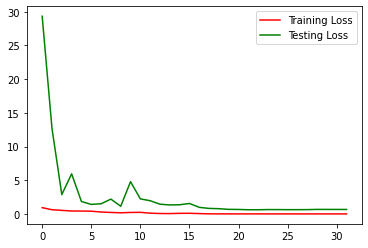

In [234]:
import matplotlib.pyplot as plt
#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
loss=model_history.history['loss']
val_loss=model_history.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
plt.plot(epochs,acc,'r',label='Training Accuracy')
plt.plot(epochs,val_acc,'g',label='Testing Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'r',label='Training Loss')
plt.plot(epochs,val_loss,'g',label='Testing Loss')
plt.legend()
plt.show()